In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, Add, AveragePooling2D
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [12]:
custom_input = Input(shape=(72, 72, 3))
base_model = VGG16(input_tensor=custom_input,
                   weights='imagenet',
                   include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 72, 72, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 72, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 36, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 36, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 36, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [3]:
base_model.layers

In [13]:
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 72, 72, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 72, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 36, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 36, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 36, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [4]:
base_input = base_model.get_layer('block2_pool')
base_output = base_model.get_layer('block5_pool')
base_input, base_output

(<keras.layers.pooling.MaxPooling2D at 0x2847ca2a8b0>,
 <keras.layers.pooling.MaxPooling2D at 0x2840e300a60>)

In [ ]:
# conv 1
# exp_conv.add(Conv2D(filters=base_units * 2, kernel_size=(3, 3), padding='same', activation=relu))
# exp_conv.add(BatchNormalization())
# x = Conv2D(filters=base_units * 2, kernel_size=(3, 3), padding='same', activation=relu)(input_layer)
# x = BatchNormalization()(x)

# conv 2
# exp_conv.add(Conv2D(filters=base_units * 2, kernel_size=(3, 3), padding='same', activation=relu))
# exp_conv.add(BatchNormalization())
# x = Conv2D(filters=base_units * 2, kernel_size=(3, 3), padding='same', activation=relu)(x)
# x = BatchNormalization()(x)

# pool and dropout
# exp_conv.add(MaxPooling2D(pool_size=(2, 2)))
# exp_conv.add(Dropout(0.2))
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.2)(x)

# conv 3
# exp_conv.add(Conv2D(filters=base_units * 4, kernel_size=(3, 3), padding='same', activation=relu))
# exp_conv.add(BatchNormalization())
# x = Conv2D(filters=base_units * 4, kernel_size=(3, 3), padding='same', activation=relu)(x)
# x = BatchNormalization()(x)

# conv 4
# exp_conv.add(Conv2D(filters=base_units * 4, kernel_size=(3, 3), padding='same', activation=relu))
# exp_conv.add(BatchNormalization())
# x = Conv2D(filters=base_units * 4, kernel_size=(3, 3), padding='same', activation=relu)(x)
# x = BatchNormalization()(x)

In [14]:
base_units = 32

base_layers = base_model.get_layer('block5_pool')
base_output = base_layers.output

# fully connected
x = Flatten()(base_output)
x = Dense(units=1024, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(units=1024, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(units=2, activation=softmax)(x)

exp_conv = Model(base_model.input, x)

exp_conv.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 72, 72, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 72, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 36, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 36, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 36, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0   

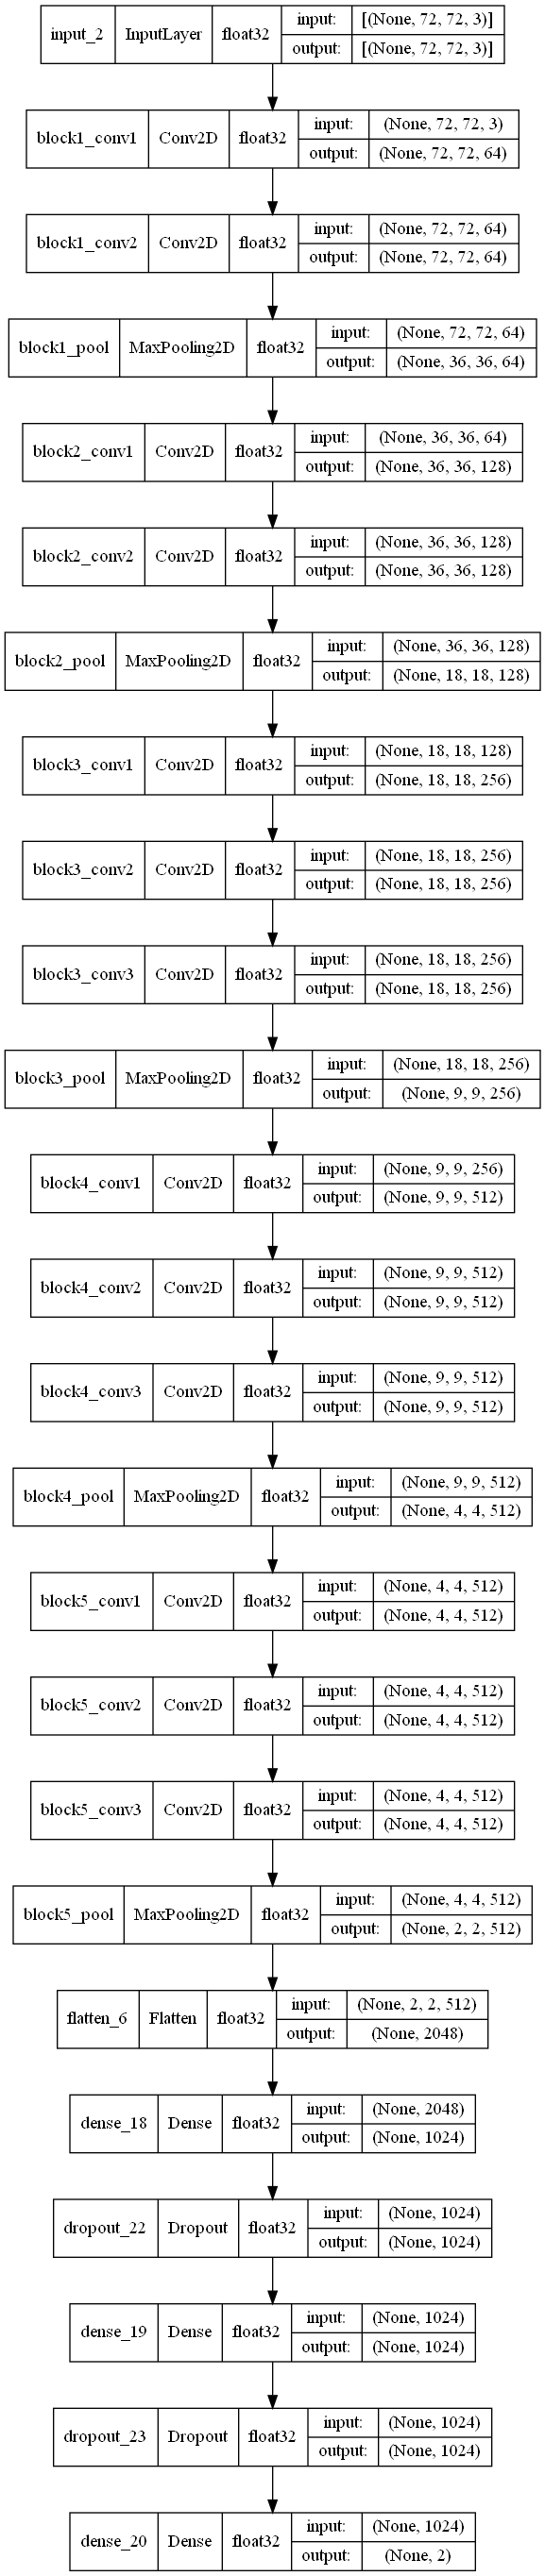

In [15]:
plot_model(exp_conv,
           to_file='custom_VggNET.png',
           show_dtype=True,
           show_shapes=True,
           show_layer_names=True)

In [4]:
exp_conv.compile(optimizer=Adam(),
                 loss=categorical_crossentropy,
                 metrics=['accuracy'])

In [5]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=np.sqrt(0.1))

check_point = ModelCheckpoint(filepath='vgg_transfer.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stop]

In [6]:
generator = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=45,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)

train_gen = generator.flow_from_directory('../input/plant-or-not/',
                                          target_size=(72, 72),
                                          batch_size=376,
                                          subset='training')
validation_gen = generator.flow_from_directory('../input/plant-or-not/',
                                               target_size=(72, 72),
                                               batch_size=376,
                                               subset='validation')

Found 42205 images belonging to 2 classes.
Found 10550 images belonging to 2 classes.


In [7]:
train_gen.class_indices

{'resized_not_plant': 0, 'resized_plant': 1}

In [8]:
balancing_weight = {0: 0.56,
                    1: 5.02}

In [9]:
model_history = exp_conv.fit(train_gen,
                             epochs=150,
                             callbacks=callbacks,
                             validation_data=validation_gen,
                             class_weight=balancing_weight)

2022-01-27 12:17:55.743579: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-01-27 12:17:59.397435: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


113/113 [==============================] - 214s 2s/step - loss: 0.6173 - accuracy: 0.7869 - val_loss: 0.5606 - val_accuracy: 0.8261
Epoch 2/150
113/113 [==============================] - 132s 1s/step - loss: 0.3645 - accuracy: 0.8594 - val_loss: 0.6850 - val_accuracy: 0.6100
Epoch 3/150
113/113 [==============================] - 121s 1s/step - loss: 0.3100 - accuracy: 0.8887 - val_loss: 0.5494 - val_accuracy: 0.8438
Epoch 4/150
113/113 [==============================] - 123s 1s/step - loss: 0.2978 - accuracy: 0.8928 - val_loss: 0.2911 - val_accuracy: 0.9144
Epoch 5/150
113/113 [==============================] - 141s 1s/step - loss: 0.2684 - accuracy: 0.9027 - val_loss: 0.2629 - val_accuracy: 0.8934
Epoch 6/150
113/113 [==============================] - 119s 1s/step - loss: 0.2465 - accuracy: 0.9114 - val_loss: 0.2557 - val_accuracy: 0.8863
Epoch 7/150
113/113 [==============================] - 122s 1s/step - loss: 0.2259 - accuracy: 0.9173 - val_loss: 0.2902 - val_accuracy: 0.8761
Epoc

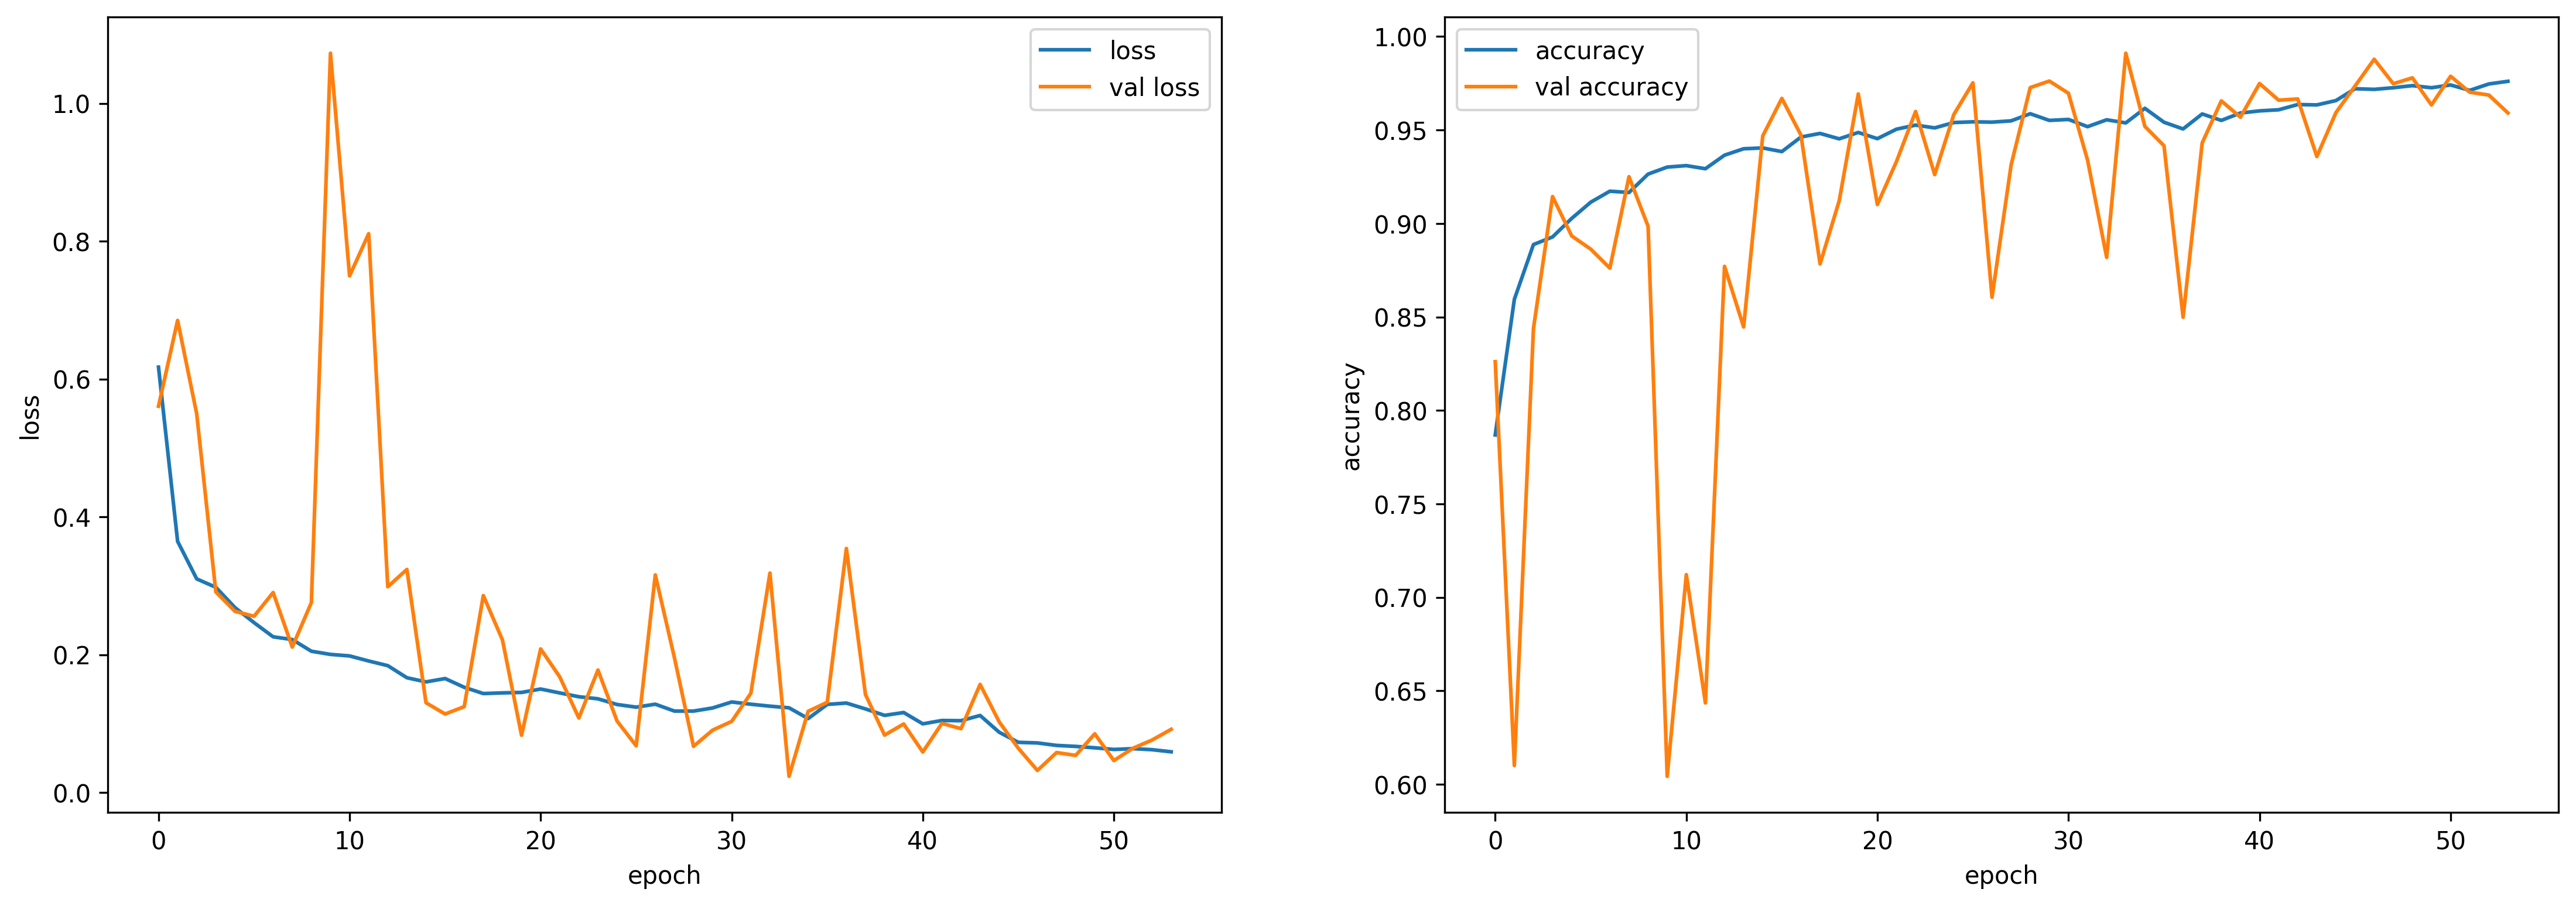

In [10]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(model_history.history['loss'])))

sns.lineplot(x=epochs, y=model_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=model_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=model_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=model_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('plant_train_history.png')
plt.show()

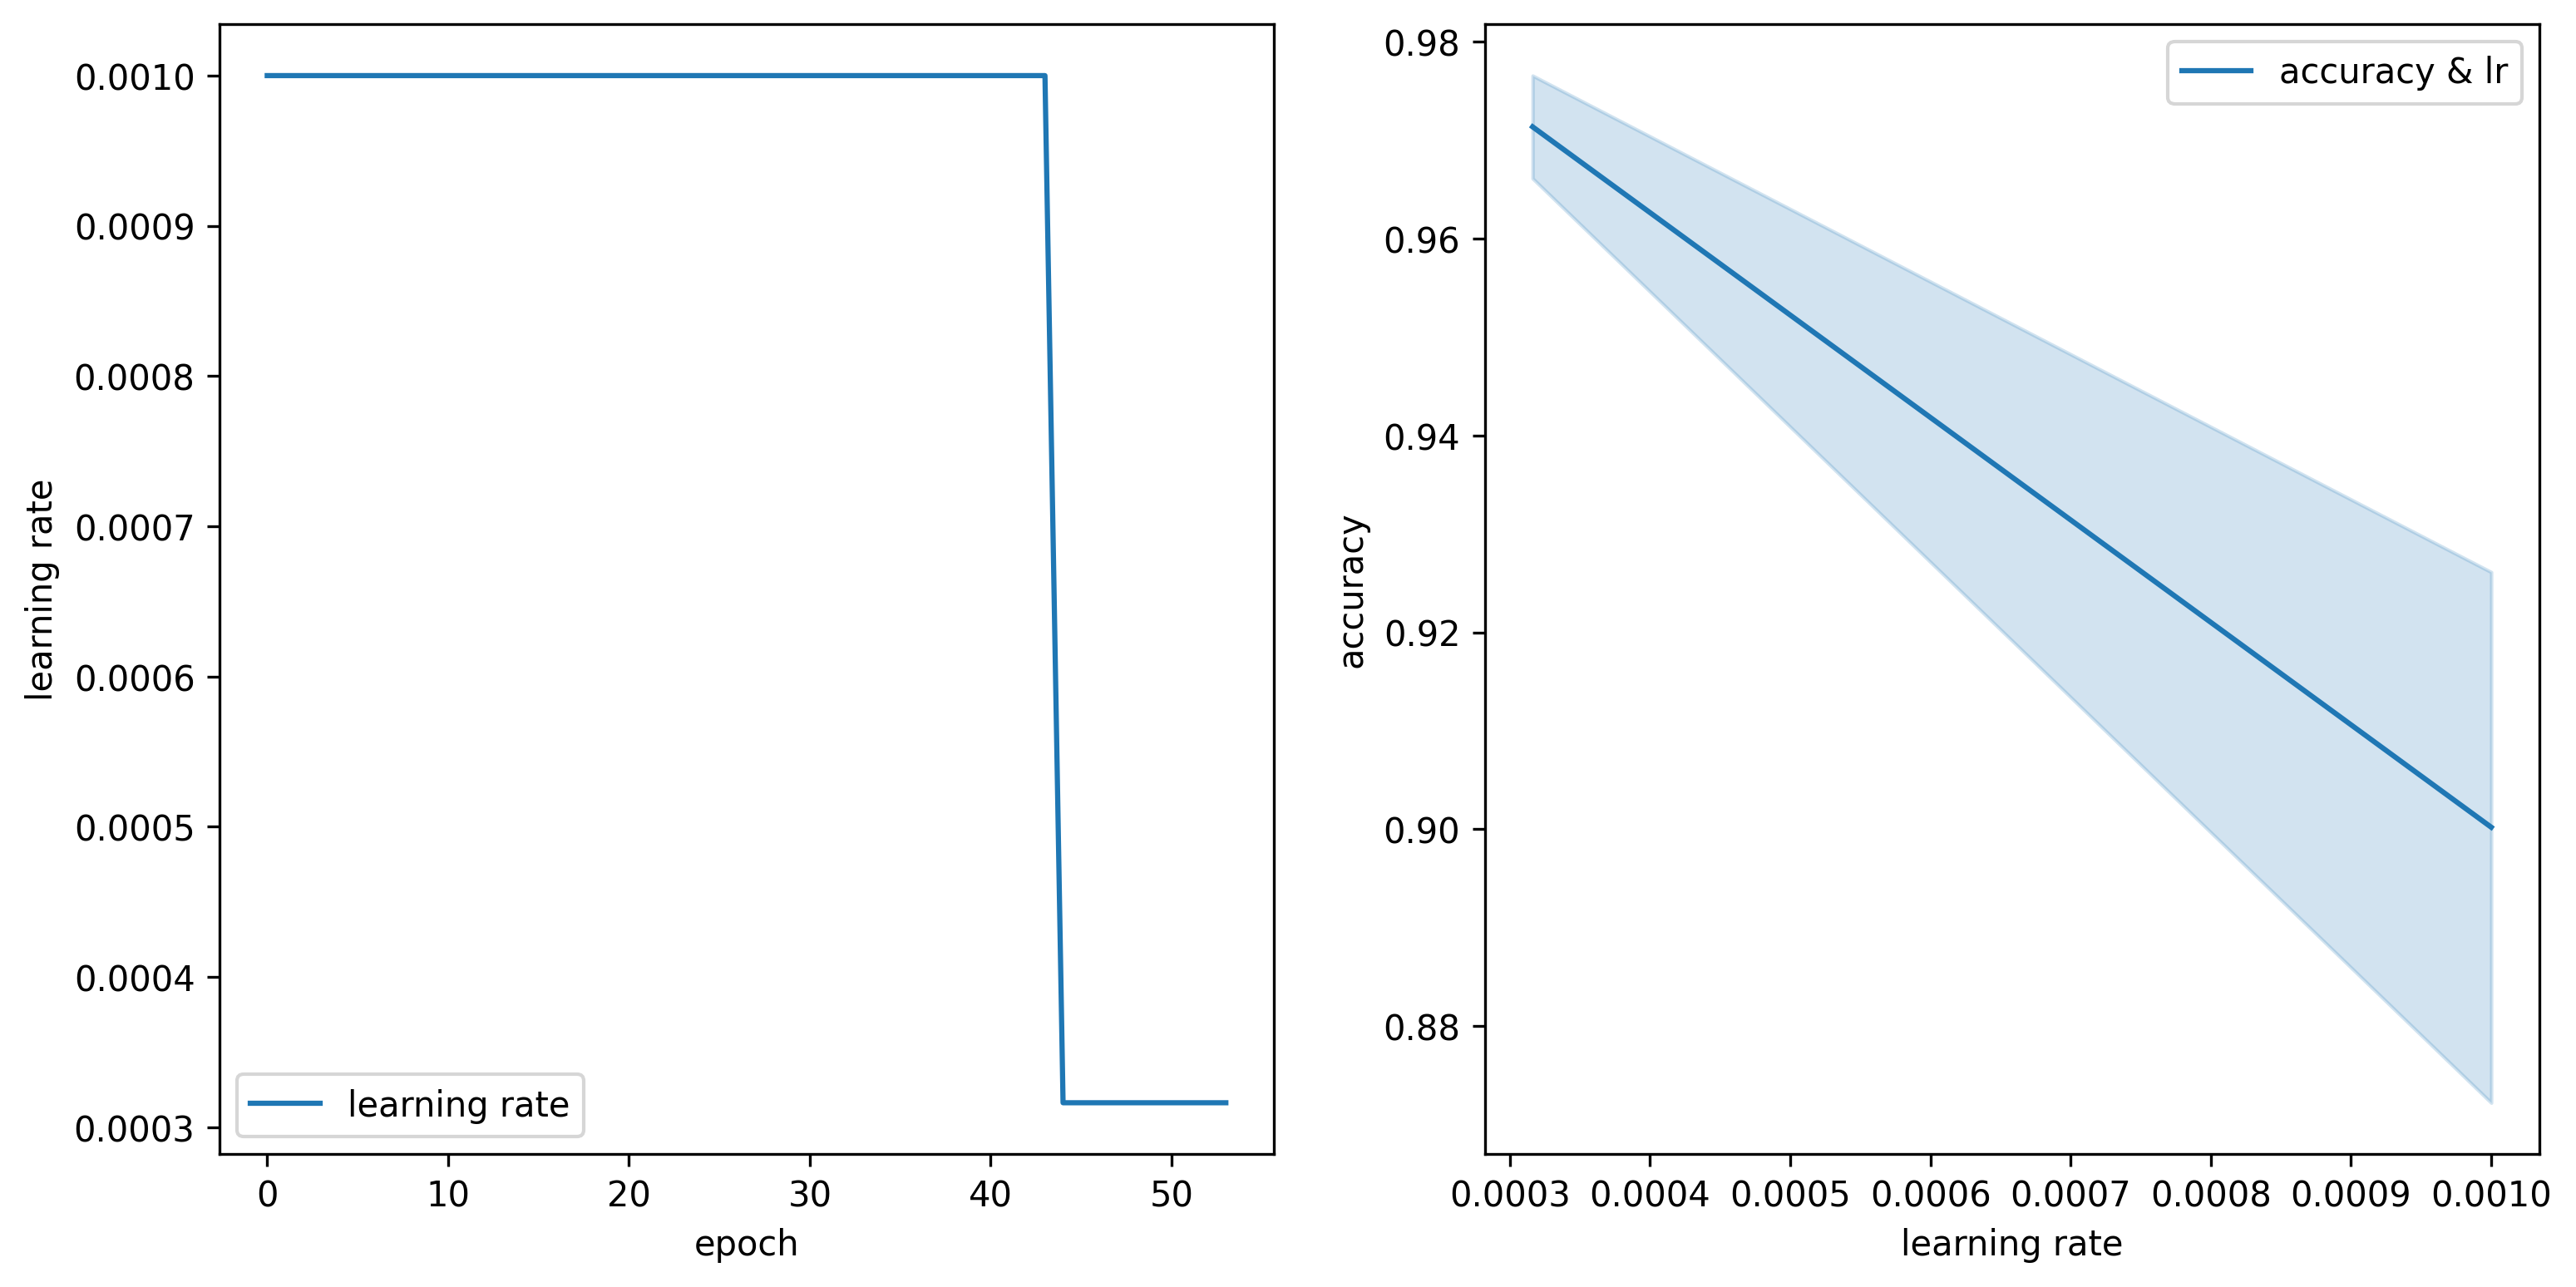

In [11]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=epochs, y=model_history.history['lr'], ax=axes[0], label='learning rate')
sns.lineplot(x=model_history.history['lr'], y=model_history.history['val_accuracy'], ax=axes[1], label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('plant_lr_history.png')
plt.show()